# H1N1 RUN without doctor recommendation DS4A Project - Team 18 - Vaccine Acceptance

---
Authorship: Marie-anne

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.inspection import permutation_importance

In [2]:
#Import dfs
features = pd.read_csv(os.path.join(os.getcwd(), 'Data/training_set_features.csv'))
labels = pd.read_csv(os.path.join(os.getcwd(), 'Data/training_set_labels.csv'))
imp_feat = pd.read_csv(os.path.join(os.getcwd(), 'Data/imputed_train_hot_encoded.csv'))
imp_feat_not_hot = pd.read_csv(os.path.join(os.getcwd(), 'Data/imputed_train.csv'))

In [3]:
# set label index
labels.set_index('respondent_id', inplace=True)

In [4]:
#IMPUTED 
imp_feat.set_index('Unnamed: 0', inplace=True)
imp_feat.sort_index(inplace=True)


In [7]:
#merge_df options

merged_df = imp_feat.join(labels)

df_h1n1 = merged_df.reset_index(drop=True).drop(['seasonal_vaccine', 'doctor_recc_h1n1'], axis=1)
df_h1n1.shape

(24036, 44)

### Train test split

In [8]:
X = df_h1n1.iloc[:, :-1]
y= df_h1n1.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=42
                                                 )
# get feature names
feature_names=list(X_train)

#check shape
print(X.shape)
X_train.shape

(24036, 43)


(21632, 43)

In [9]:
# # IMPUTED Scaling and 
X_train = StandardScaler().fit_transform(X_train)
print(X_train.shape)
X_train

X_val = StandardScaler().fit_transform(X_val)

(21632, 43)


In [10]:
# Create model_dict

models = dict()

models['LR'] = LogisticRegression(C=0.5, penalty='l2')
models['SVM'] = SVC(kernel='linear', C=0.2)
models['RF'] = RandomForestClassifier(criterion= 'entropy', max_depth=11, n_jobs=-1)
models['XGB'] = xgb.XGBClassifier(objective= 'binary:logistic',
                        eval_metric = 'aucpr',
                        learning_rate = 0.01, 
                        max_depth=3,
                        n_estimators=1475,
                        min_child_weight=1,
                        gamma=0.7,
                        alpha=1e-06,
                        subsample=0.5,
                        colsample_bytree=0.85,
                        nthread=4,
                        scale_pos_weight=1,
                        seed=42, metrics='auc')

## Feature importances

In [11]:
def train_model(name, model):
    if name == 'XGB':
        X_train_df= pd.DataFrame(X_train, columns=feature_names)
        clf = model.fit(X_train_df, y_train)
    else:
        clf = model.fit(X_train, y_train)
    
    return clf

In [12]:
# Fit models
for name, model in models.items():
    models[name] = train_model(name, model)

[20:21:43] WARNING: ../src/learner.cc:516: 
Parameters: { metrics } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [13]:
# Define basic features importances:
def get_feature_importance(name, model):
    '''return classical feature importances
    Args:
        -name:str
        -model: trained model
    return importance as a df    
    '''
    
    if name == 'LR':
        importance = model.coef_
        importance = pd.DataFrame(importance.T, columns=['LR'], index=feature_names)
        importance.sort_values('LR', ascending=True, inplace=True)
       
    if name == 'SVM':
        importance = model.coef_
        importance = pd.DataFrame(importance.T, columns=['SVM'], index=feature_names)
        importance.sort_values('SVM', ascending=True, inplace=True)
        
    if name == 'RF': 
        importance = model.feature_importances_
        importance = 100.0 * (importance / importance.sum())
        importance = pd.DataFrame(importance.T, columns=['RF'], index=feature_names)
        importance.sort_values('RF', ascending=True, inplace=True)
 
    if name == 'XGB':
        importance = model.feature_importances_
        importance = 100.0 * (importance / importance.sum())
        importance = pd.DataFrame(importance.T, columns=['RF'], index=feature_names)
        importance.sort_values('RF', ascending=True, inplace=True)
         
    return importance

In [14]:
# Define permutation features importances:
def permutation_feature_importance(name, model):
    '''return permutation feature importances and plot means
    Args:
        -name:str
        -model: trained model
    return mean importance as a df    
    '''
    
    if name == 'XGB':
        X_val_df= pd.DataFrame(X_val, columns=feature_names)
        importance = permutation_importance(model, X_val_df, y_val, n_repeats=10, random_state=42, n_jobs=-1)

    else:
        importance = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    
    sorted_idx = importance.importances_mean.argsort()
    importance = pd.DataFrame(importance.importances_mean[sorted_idx], X.columns[sorted_idx], columns=[name])
    
    return importance

def plot_perm_FI(result):
    sorted_idx = result.importances_mean.argsort()
    fig, ax = plt.subplots(1,1, figsize=(5,10))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()

In [16]:
import shap

def shap_feature_importance(name, model):
    
    '''return SHAP feature importances and plot summary(violin, bar)
    Args:
        -name:str
        -model: trained model
    return mean importance as a df    
    '''
    #model.fit(X_train, y_train)
    if name == 'XGB' or name == 'RF': 
        explainer = shap.TreeExplainer(model)
    
    if name == 'LR':
        explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    
    if name == 'SVM': 
        pass
#         X_train_summary = shap.kmeans(X_train, 10)
#         explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

    shap_values_train = explainer.shap_values(X_train)
    shap_values_test = explainer.shap_values(X_val)
    
    return shap_values_train, shap_values_test

# 1. Classic

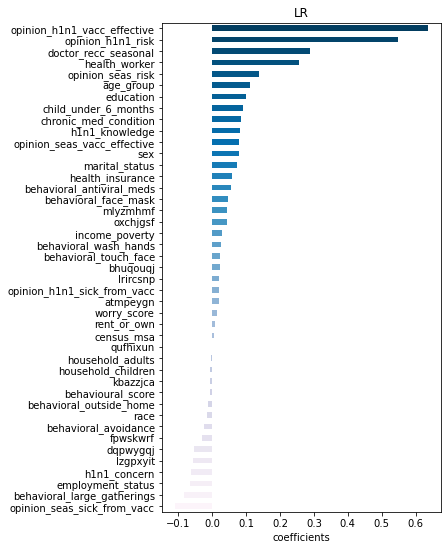

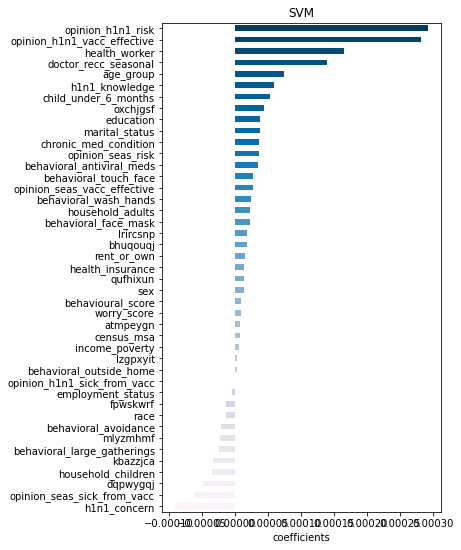

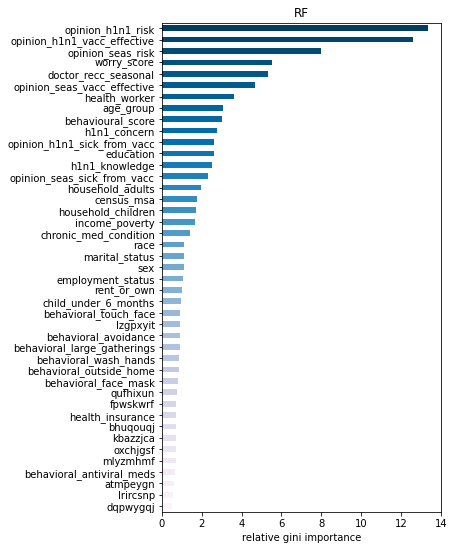

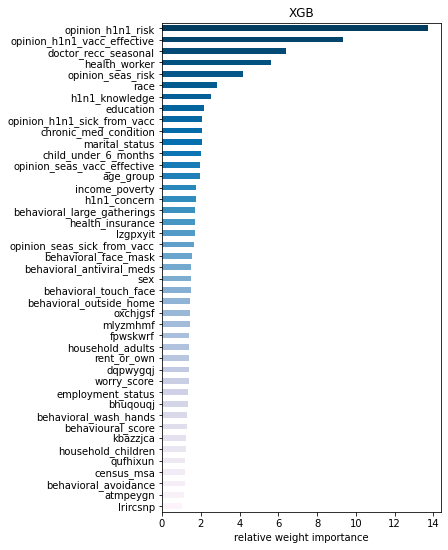

In [19]:
classic_feat_imp = dict()

for name, model in models.items():
    classic = get_feature_importance(name, model)
    classic_feat_imp[name]=classic
    classic.plot.barh(figsize=(5,9), color=[sns.color_palette(palette='PuBu', n_colors=len(feature_names))], legend=False, title=name)
    if name=='LR' or name=='SVM':
        plt.xlabel('coefficients')
    if name=='RF':
        plt.xlabel('relative gini importance')    
    if name=='XGB':
        plt.xlabel('relative weight importance')
    
    plt.savefig(os.path.join(os.getcwd(), 'Feat_imp_plot/HWoDr{}_classic.png'.format(name)), bbox_inches='tight')

df = pd.concat(classic_feat_imp.values(), axis=1)

with pd.ExcelWriter('Results/results_h1n1WoDr_feature_imp.xlsx', engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='classic')

# 2. Permutation

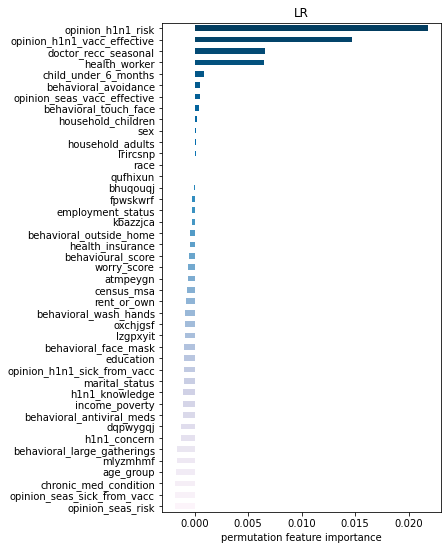

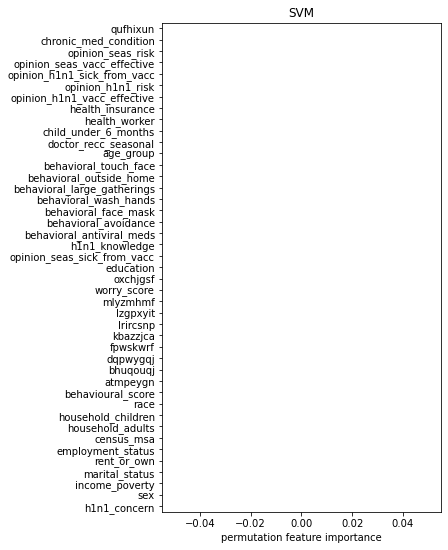

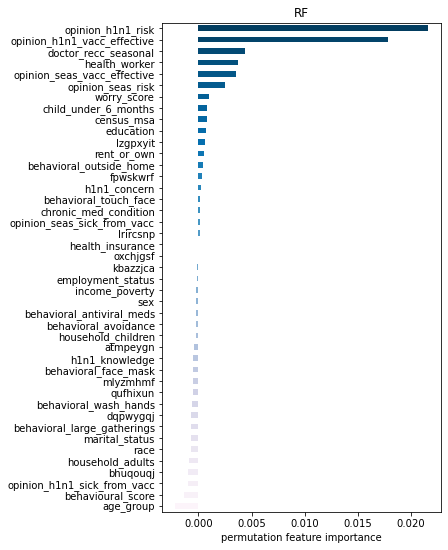

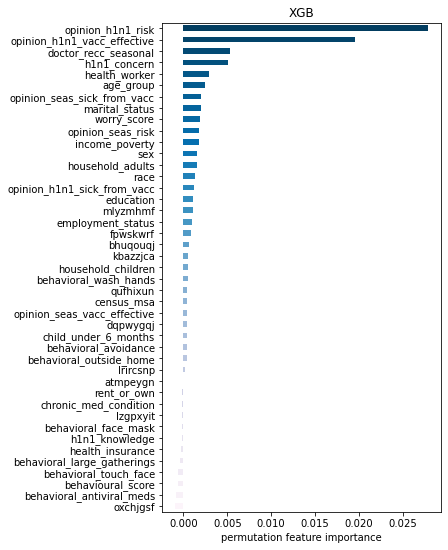

In [20]:
perm_feat_imp = dict()

for name, model in models.items():
    perm = permutation_feature_importance(name, model)
    perm_feat_imp[name]=perm
    perm.plot.barh(figsize=(5,9), color=[sns.color_palette(palette='PuBu', n_colors=len(feature_names))], legend=False, title=name)
    plt.xlabel('permutation feature importance')

    plt.savefig(os.path.join(os.getcwd(), 'Feat_imp_plot/HWoDr{}_perm.png'.format(name)), bbox_inches='tight')

df_2 = pd.concat(perm_feat_imp.values(), axis=1)

with pd.ExcelWriter('Results/results_h1n1WoDr_feature_imp.xlsx', engine='openpyxl', mode='a') as writer:
        df_2.to_excel(writer, sheet_name='permutation')

# 3. SHAP

In [21]:
shap_feat_imp = dict()

for name, model in models.items():
    if name == 'SVM': 
        continue
    shap_res = shap_feature_importance(name, model)
    shap_feat_imp[name]=shap_res
    


In [22]:
df_LR = pd.DataFrame(np.abs(shap_feat_imp['LR'][0]).mean(0), index=X.columns, columns=['LR']).sort_values('LR', ascending=False)
df_RF = pd.DataFrame(np.abs(shap_feat_imp['RF'][0][0]).mean(0)+ np.abs(shap_feat_imp['RF'][0][1]).mean(0), 
                     index=X.columns, columns=['RF']).sort_values('RF', ascending=False)
df_XGB = pd.DataFrame(np.abs(shap_feat_imp['XGB'][0]).mean(0), index=X.columns, columns=['XGB']).sort_values('XGB', ascending=False)

In [23]:
df_3 = pd.concat([df_LR, df_RF, df_XGB], axis=1)
with pd.ExcelWriter('Results/results_h1n1WoDr_feature_imp.xlsx', engine='openpyxl', mode='a') as writer:
        df_3.to_excel(writer, sheet_name='SHAP')